In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers.legacy import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [27]:
#Load dataset

data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


dataset/happy
dataset/sad
dataset/fear
dataset/surprise
dataset/neutral
dataset/angry
dataset/disgust


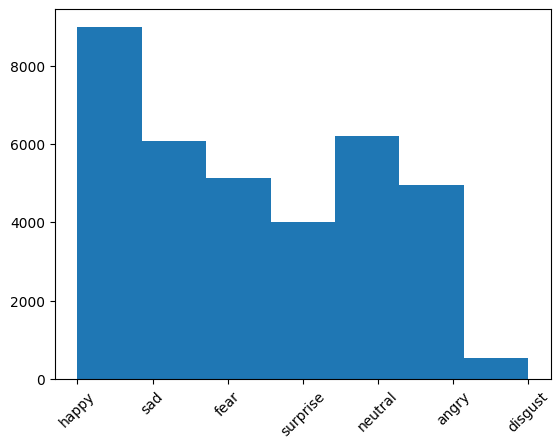

In [28]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

In [29]:
from sklearn.utils.class_weight import compute_sample_weight

# Load the images and their labels
image_dir = "./dataset/"
labels = []
images = []
for folder in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, folder)):
        if file.endswith(".jpg"):
            images.append(img_to_array(load_img(os.path.join(image_dir, folder, file), color_mode="grayscale")))
            labels.append(folder)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode the labels
label_dict = {label: i for i, label in enumerate(np.unique(labels))}
labels = to_categorical(np.vectorize(label_dict.get)(labels))

# Convert one-hot encoded labels back to their original form
original_labels = np.argmax(labels, axis=1)

# Define the mapping
emotion_to_vac = {
    'Happy': [0.8, 0.8],
    'Angry': [-0.8, 0.8],
    'Surprise': [0.8, 0.8],
    'Fear': [-0.8, 0.8],
    'Sad': [-0.8, -0.8],
    'Disgust': [-0.8, 0.8],
    'Neutral': [0.0, 0.0]
}

# Define class_names, to be used for CM
class_names = list(emotion_to_vac.keys())

# Reverse the label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Convert integer labels back to emotion names and capitalize them
emotion_labels = [reverse_label_dict[label].capitalize() for label in original_labels]

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=original_labels)
n_samples = len(original_labels)
n_classes = len(np.unique(original_labels))
counts = np.bincount(original_labels)
class_weights = n_samples / (n_classes * counts)

# Split the data into training and testing sets
train_images, test_images, train_vac_labels, test_vac_labels = train_test_split(images, vac_labels, test_size=0.3, stratify=original_labels, random_state=42)


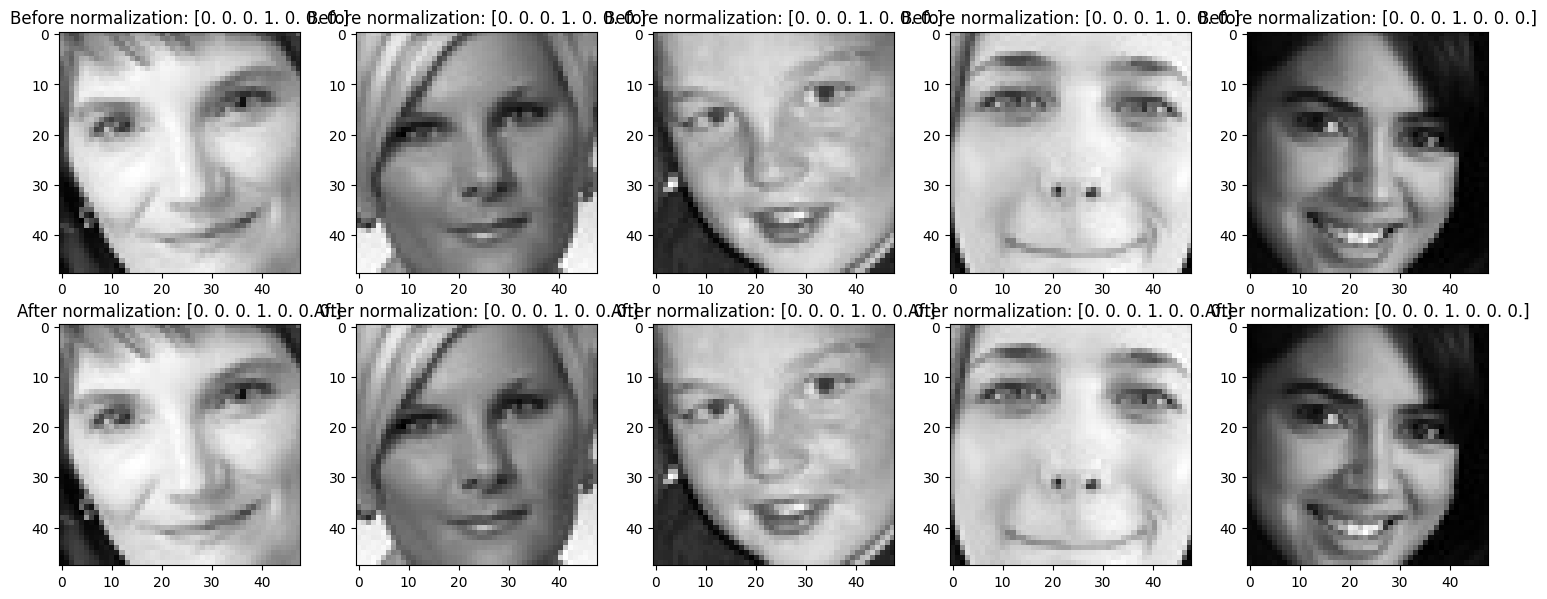

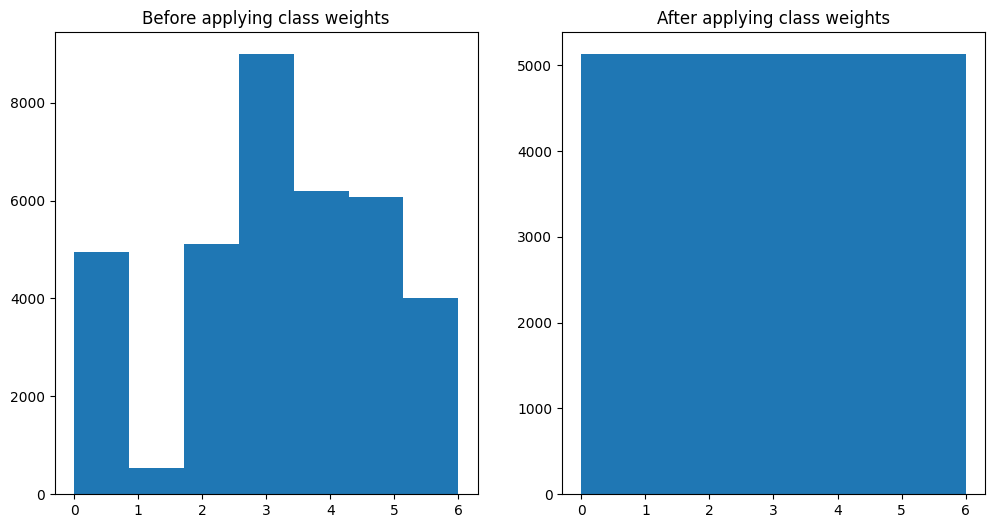

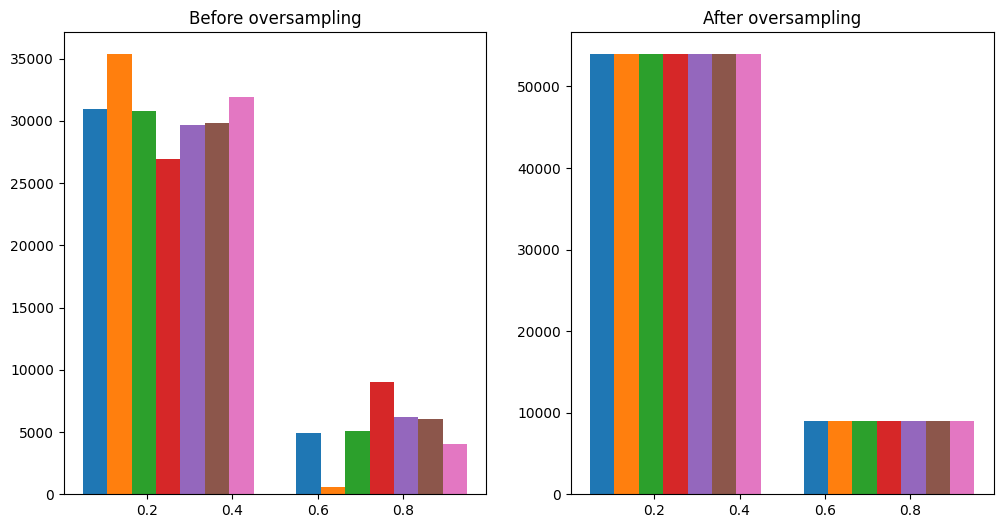

In [30]:
from imblearn.over_sampling import RandomOverSampler

# Visualize some images before and after normalization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Before normalization
    axs[0, i].imshow(images[i] * 255, cmap='gray')
    axs[0, i].set_title(f'Before normalization: {labels[i]}')
    # After normalization
    axs[1, i].imshow(images[i], cmap='gray')
    axs[1, i].set_title(f'After normalization: {labels[i]}')
plt.tight_layout()
plt.show()

# Create an array of class weights for each sample
sample_weights = class_weights[original_labels]

# Plot the distribution of your labels before and after applying class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(original_labels, bins=n_classes)
axs[0].set_title('Before applying class weights')
axs[1].hist(original_labels, weights=sample_weights, bins=n_classes)
axs[1].set_title('After applying class weights')
plt.show()

# Find the number of unique classes in your labels
n_classes = len(np.unique(np.concatenate((np.argmax(train_vac_labels, axis=1), np.argmax(test_vac_labels, axis=1)))))

# Perform oversampling
ros = RandomOverSampler(random_state=0)
images_resampled, labels_resampled = ros.fit_resample(images.reshape(images.shape[0], -1), labels)
images_resampled = images_resampled.reshape(-1, images.shape[1], images.shape[2], images.shape[3])

# Visualize the distribution of your data after oversampling
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(labels, bins=n_classes)
axs[0].set_title('Before oversampling')
axs[1].hist(labels_resampled, bins=n_classes)
axs[1].set_title('After oversampling')
plt.show()

In [41]:
import cv2
import numpy as np

def preprocess_images(images):
    # Convert to color
    color_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in images]
    return np.array(color_images)

# Apply the preprocessing to both the training and testing data
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [42]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers.legacy import Adam
from keras.regularizers import l1_l2

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="linear")(headModel)  # Change to 2 outputs with linear activation

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
opt = Adam(lr=1e-4, decay=1e-4 / 100)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])  # Change loss to mse

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
def display_samples(images, labels, predictions, class_names):
    # Get the unique labels
    unique_labels = np.unique(labels)

    # For each unique label
    for label in unique_labels:
        # Get the indices of images with this label
        indices = np.where(labels == label)[0]

        # Choose one random index
        sample_index = np.random.choice(indices, 1)

        # Get the sample image and its corresponding prediction
        sample_image = images[sample_index]
        sample_prediction = predictions[sample_index]

        # Display the sample image with the predicted valence and arousal rates
        plt.imshow(sample_image[0])
        # Get the emotion name from the class_names
        emotion_name = class_names[int(label)]
        plt.text(sample_image[0].shape[1] - 20, sample_image[0].shape[0] - 10, 
                 f'Emotion: {emotion_name}, Valence: {sample_prediction[0, 0]:.2f}, Arousal: {sample_prediction[0, 1]:.2f}', 
                 color='red')
        plt.show()
        print(emotion_name)

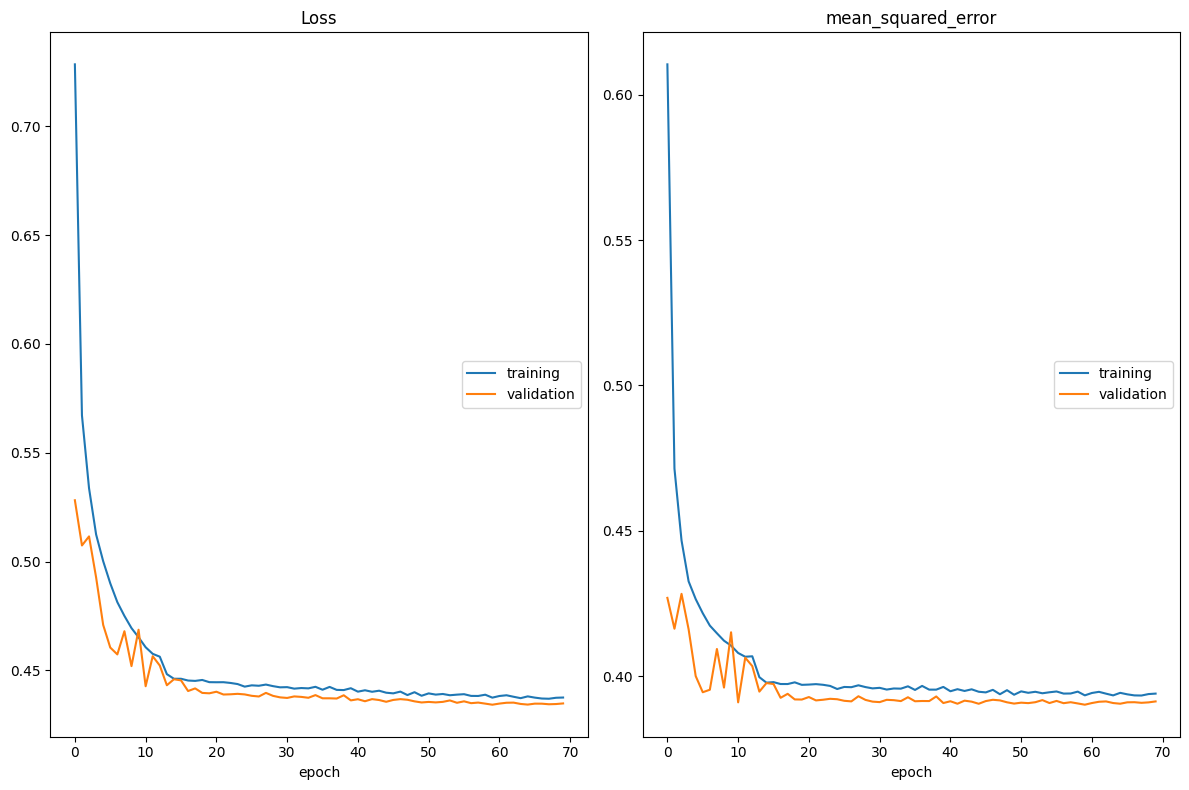

Loss
	training         	 (min:    0.437, max:    0.728, cur:    0.438)
	validation       	 (min:    0.434, max:    0.528, cur:    0.435)
mean_squared_error
	training         	 (min:    0.393, max:    0.610, cur:    0.394)
	validation       	 (min:    0.390, max:    0.428, cur:    0.391)

Epoch 70: saving model to model_weights.h5
Restoring model weights from the end of the best epoch: 60.
785/785 [==============================] - 16s 20ms/step - loss: 0.4376 - mean_squared_error: 0.3940 - val_loss: 0.4348 - val_mean_squared_error: 0.3913 - lr: 1.0000e-05
Epoch 70: early stopping
 10/337 [..............................] - ETA: 3s

2023-12-25 21:41:20.927178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


337/337 [==============================] - 4s 11ms/step


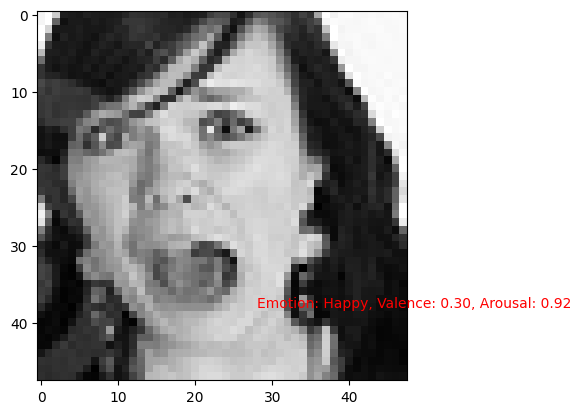

Happy


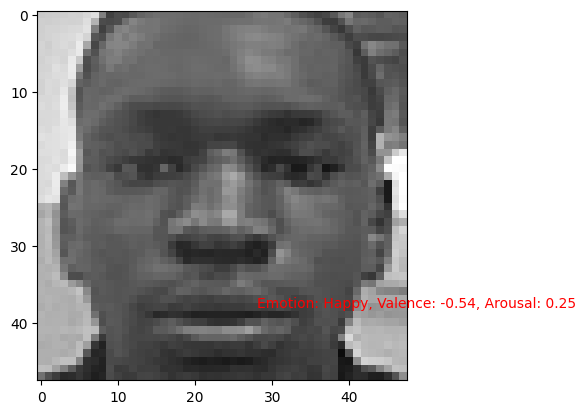

Happy


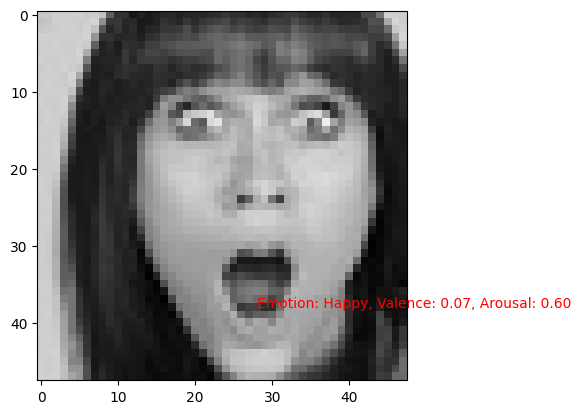

Happy


In [44]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
csv_logger = CSVLogger('training.log')

tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

# Use this callback in your model.fit call
callbacks= [PlotLossesKeras(), checkpoint, reduce_lr, csv_logger, tensorboard]
# Train the model without the ScatterPlotCallback.
model.fit(train_images,
          train_vac_labels,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(test_images, test_vac_labels),
          callbacks=callbacks+[early_stopping])

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Display 1 sample image from each emotion
display_samples(test_images, test_vac_labels, predictions, class_names)


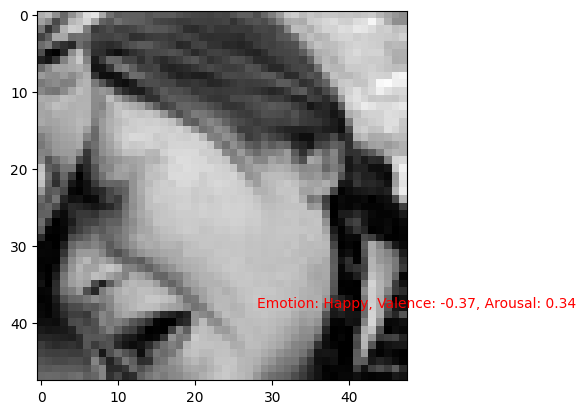

Happy


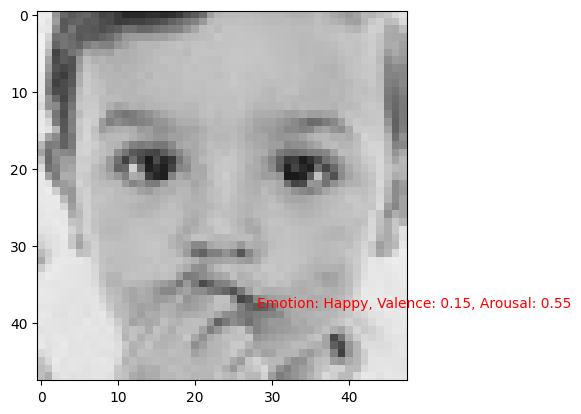

Happy


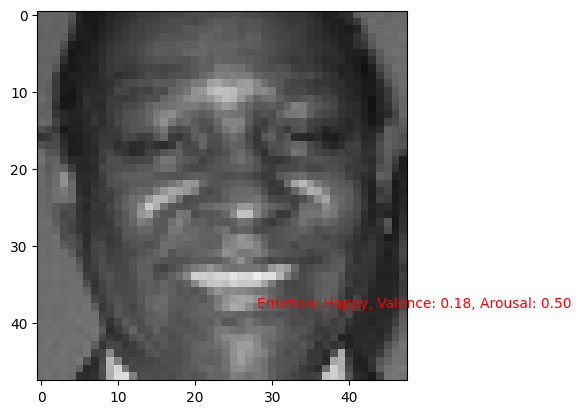

Happy


In [45]:
# Display 1 sample image from each emotion
display_samples(test_images, test_vac_labels, predictions, class_names)

In [83]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model's weights
model.save_weights("model_weights.h5")

# Save entire model
model.save("model.h5")

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 2s 5ms/step


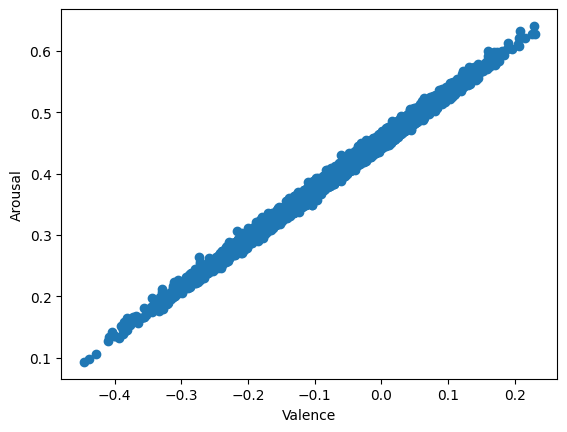

In [82]:
import matplotlib.pyplot as plt

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Plot the predicted valence-arousal coordinates
plt.scatter(predictions[:, 0], predictions[:, 1])
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()